<a href="https://colab.research.google.com/github/benzerer/google-drive-NFT-generator/blob/main/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generate NFT and save then on Google Drive**

license: MIT

made by [Nopdanai](https://www.facebook.com/bn.intm/)

wann buy me a coffee?
- wallet: 0x51A1A1588F07aE892E322f5Fb4d7D32d039e527f
- [Buy Me A Coffee](https://www.buymeacoffee.com/bintm)

In [536]:
#@title **First**, {"display-mode":"form"}
#@markdown Run the cell (Click on `▶` on the left of this cell) to connect to Google drive.

#@markdown This will lead you to sign in step.

!pip install -q colorama
MOUNTPOINT = "/content/drive"

from google.colab import drive as drive
drive.mount(MOUNTPOINT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [559]:
#@title **After that**, {"display-mode":"form"}
#@markdown Tell me where is your NFT folder in google drive.

#@markdown Example: /Project1/myNFT.

path = "Newocean/Decenzor/Kiosk NFT/NFT sample" #@param {"type":"string"}

#@markdown Then, run the cell `▶`

BASE = f"{MOUNTPOINT}/MyDrive/{path}"

import os
import logging
import json
from colorama import Fore,Style
from tqdm import tqdm

executable = False

def output (msg:str, color:str=Fore.RED) -> None:
  span = len(msg) + 4
  bar = "="*span
  print(color)
  print(bar)
  print("|",msg,"|")
  print(bar)
  print(Style.RESET_ALL)

if not path:
  output("Please tell me the folder name!")
else:
  if not os.path.isdir(BASE):
    output("Please tell me the correct folder name!")
  else:
    executable = True
    output("Shall we start? :)", Fore.GREEN)
    print()


| Shall we start? :) |




Mapping image files: 3it [00:00, 205.80it/s]
Layering: 100%|██████████| 2/2 [00:00<00:00, 12264.05it/s]


| All images loaded |

Attributes:
- 1 Background : 
	- Blue Background
	- Pink Background
	- Green Background
- 2 Face : 
	- Sleepy
	- Surprised
	- Smile
- 3 Outfit : 
	- Cape Shirt
	- Collared Shirt
	- Striped Shirt

Sample: Check the completeness of images before continue.

*This is not your NFTs' actual size.


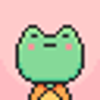

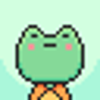

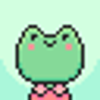

In [537]:
#@title **Now,** {"display-mode":"form"}

#@markdown Run this cell `▶` to load all images before starting NFT generation.

from PIL import Image, PngImagePlugin
import datetime
import os
import pandas as pd

def generate_ctn (s:str) -> dict:
  global BASE
  outer_path = f"{BASE}/{s}"
  id, name_idx = s.strip().split("_", maxsplit=1)
  if not os.path.isdir(outer_path):
    return None
  inner_paths = os.listdir(outer_path)
  inner_paths = list(map(
      lambda p: (p.rsplit(".", maxsplit=1)[0], f"{outer_path}/{p}"),
      inner_paths))
  vars = filter(lambda p: os.path.isfile(p[1]), inner_paths)
  vars = dict(map((lambda v: (v[0], Image.open(v[1]))), vars))
  if not len(vars):
    return None
  
  result = {
      "name": name_idx,
      "vars": vars,
      "cond": [],
      "amount": len(inner_paths)
  }

  return (int(id), result)

def gen_NFTs_df (ctn:dict) -> pd.DataFrame:
  primer = (
      (ctx['name'], ctx['vars'].keys())
      for ctx in ctn.values()
      )
  sr = (
      pd.DataFrame(primer, columns=['name', 'vars'])
      .explode('vars')
      .groupby('name')
      .vars.apply(set)
  )
  cols = sr.index
  all_NFT, *layers = sr.__iter__()
  all_NFT = ([var] for var in all_NFT)
  for layer_vars in tqdm(layers, 'Layering'):
    all_NFT = tuple(
        (*stacked_layer, new_layer_var)
        for stacked_layer in all_NFT
        for new_layer_var in layer_vars
    )
  return pd.DataFrame(all_NFT, columns=cols)

def gen_from_precursor (precursor:dict) -> PngImagePlugin:
  global ctn, NFT_base_layer, NFT_layers
  lid, lnid = NFT_base_layer
  result = ctn[lid]['vars'].get(precursor.get(lnid)).copy()
  for lid, lnid in NFT_layers:
    current_layer = ctn[lid]['vars'].get(precursor.get(lnid))
    if current_layer:
      result.paste(current_layer, (0,0), current_layer)
  return result

def NFT_func_dec (func):
  def inner (*args, **kwargs):
    result = func(*args, **kwargs)
    return result.reset_index(drop=True) , result.to_dict(orient='records')
  return inner

random_NFT = NFT_func_dec(lambda sampling, source: source.sample(sampling))

thanos_snap = NFT_func_dec(lambda source: source.sample(source.shape[0]//2))

if executable:

  ctn = dict(
      filter(
          lambda x: x,
          tqdm(
          map(
              generate_ctn,
              sorted(os.listdir(BASE)
              )
              )
          , "Mapping image files")
          )
      )
  NFT_base_layer, *NFT_layers = zip(
      ctn.keys(),
      (ctx['name'] for ctx in ctn.values())
      )

  df = gen_NFTs_df(ctn)
  
  output("All images loaded", Fore.GREEN)

  loopset = set()
  print("Attributes:")
  for idx, ctx in ctn.items():
    if ctx['name'] in loopset:
      continue
    vars = "".join("\n\t- "+v for v in ctx["vars"].keys())
    print(f"- {idx} {ctx['name']} : {vars}")
  
  print("\nSample: Check the completeness of images before continue.")
  print("\n*This is not your NFTs' actual size.")

  for NFT in random_NFT(3, df)[1]:
    image = gen_from_precursor(NFT)
    factor = 100 / min(image.size)
    new_size = map(lambda x: round(x*factor), image.size)
    image = image.resize(new_size)
    display(image)

else:

  output("Setting step was not done properly")

In [585]:
#@title **Let's go!** {"display-mode":"form"}

#@markdown How many NFT do you want to generate? (minimum = 5, maximum = 2,000)
total = 9 #@param {type:"slider", min:5, max:2000, step:1}

#@markdown Do you want to generate excel?
excel = False #@param {type:"boolean"}

#@markdown Do you want to randomly halve the amount of generated NFTs?
thanos = False #@param {type:"boolean"}

#@markdown Do you want to generate minimal metadata?

#@markdown ```{"attributes":[{"trait_type":"xxx","value":"yyy"}]}```
metadata = False #@param {type:"boolean"}

#@markdown Don't forget to run the cell `▶`

if executable:
  NFTs_df, NFTs_dct = random_NFT(total, df)

  dt = datetime.datetime.now()
  dt = f"{dt.year}{dt.month:02}{dt.day:02}{dt.hour:02}{dt.minute:02}"

  output_folder_name = f"{dt}_NFT_output"
  output_path = f'{MOUNTPOINT}/MyDrive/{output_folder_name}'

  if not os.path.isdir(output_path):
    os.mkdir(output_path)

  output(f'Output folder: "{output_folder_name}" at Google drive root', Fore.GREEN)

  if thanos:
    NFTs_df, NFTs_dct = thanos_snap(NFTs_df)
    print('Thanosed ✔')

  rarity_map = (
      NFTs_df
      .melt()
      .assign(ratio=1)
      .groupby(['name', 'value'])
      .count()
      .assign(
          ratio=(lambda df: 
                df['ratio']*100 / df.groupby(level=0)['ratio'].transform('sum'))
      )
      .style
      .background_gradient('Wistia_r')
      .format('{:.2f}%'))

  if excel:
    with pd.ExcelWriter(f'{output_path}/stats.xlsx') as writer:
      rarity_map.to_excel(writer, sheet_name='rarity')
      NFTs_df.to_excel(writer, sheet_name='attributes')
      print('Excel generated ✔')

  print('Rarity map')
  display(rarity_map)

  parse_attributes = (
      lambda dct: json.dumps({
          "attributes": list(
              {"trait_type":attr[0],"value":attr[1]}
              for attr in dct.items()
              )
          },
        ensure_ascii=False,
        indent=2
        )
      )

  if metadata:
    metadata_path = f"{output_path}/metadata"
    if not os.path.isdir(metadata_path):
      os.mkdir(metadata_path)

    ms1 = tqdm(map(parse_attributes, NFTs_dct), "Parsing metadata")
    ms2 = tqdm(enumerate(ms1), "Writing metadata")

    for mid, mctn in ms2:
      with open(f"{metadata_path}/{mid}.txt", "w") as f:
        f.write(mctn)
    print('Metadata generated ✔')

  image_path = f"{output_path}/image"
  if not os.path.isdir(image_path):
    os.mkdir(image_path)

  is1 = tqdm(map(gen_from_precursor,NFTs_dct), "Generate images")
  is2 = tqdm(enumerate(is1), "Save images")

  for iid, ictn in is2:
    ictn.save(f'{image_path}/{iid}.png', format="png")
  print('Images saved ✔')


| Output folder: "202207131006_NFT_output" at Google drive root |

Rarity map



Generate images: 0it [00:00, ?it/s]

Generate images: 9it [00:00, 144.11it/s]
Save images: 9it [00:00, 152.93it/s]

Images saved ✔
